# Implantation en PyTorch de l'algorithme de classification semi-supervisée Fixmatch

Dans ce notebook, vous allez compléter le code de l'algorithme Fixmatch, et le tester sur CIFAR10 en utilisant seulement 250 exemples supervisés et le reste en non-supervisé.

À faire :
- compléter le code de la fonction `step()`, voir plus bas
- réaliser un apprentissage supervisé sur les 250 exemples supervisés, pour comparaison avec le même modèle entraîné avec Fixmatch.


<img src="https://www.irit.fr/~Thomas.Pellegrini/ens/M2ML3/fixmatch_diagram.png" alt="diagram FixMatch" width="800"/>


# Contexte et notations

## Apprentissage semi-supervisé

- Problème de classification à $L$ classes exclusives
- Exemples labélisés : $\cal{X} = \{(x_b,p_b) : b \in (1,...,B)\}$
- Exemples non-labélisés : $\cal{U} = \{u_b : b \in (1,...,\mu B)\}$
- Le modèle prédit un label pour l'entrée $x$ : $q = p_m (\text{target}|x; \theta)$
- Cross-Entropy : $H(p, q)$
- Augmentations faibles (weak): $\alpha(x)$. Par exemple, rotations, translations, flips, etc
- Augmentations fortes (strong) : $\cal{A}(x)$. Éventuellement, on pourrait utiliser des augmentations qui s'apprennent : AutoAugment, CTAugment, etc


## Loss sur les données supervisées :

- Cross-Entropy loss : $L(x, \text{class}) = - \log(q[\text{class}])$


## Loss sur les données non-supervisées :

- Consistency loss avec $\cal{l}^2$ : $L(x) = |p_m (\text{target}| \alpha_1(x); \theta) - p_m (\text{target}| \alpha_2(x); \theta)|^2$
- Ou Consistency loss avec Cross-Entropy : $p_m (\text{target}| \alpha_1(x); \theta) \rightarrow \text{target}$, $p_m (\text{target}| \alpha_2(x); \theta) \rightarrow \text{prédiction}$

## Pseudo-labeling

1) Le modèle génère des prédictions utilisées ensuite comme labels pour les données non-su+pervisées.

2) Fixmatch utilise des labels binaires ("hard labels"), et sélectionne uniquement celles dont la probabilité donnée par le modèle est supérieure à un seuil prédéfini :  

- Prédiction : $q = p_m (\text{target}|x; \theta)$
- Pseudo-label : $\hat{q} = \text{argmax}(q)$
- "Hard" label : $\max(q) \ge \tau$
- Loss :
  - $H(\hat{q}, q)$ if $\max(q) \ge \tau$
  - $0$ sinon


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lrs
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision import transforms as T
from torchvision.datasets.cifar import CIFAR10
from torchvision.models.resnet import resnet18
from torchvision.utils import make_grid

import matplotlib.pylab as plt
%matplotlib inline


In [ ]:
num_train_samples_per_class = 25
num_classes = 10
mu_ratio = 7
weight_decay = 0.0005

device = 'cuda'
batch_size = 128  # 64 dans le papier

# CIFAR10 dataset

In [ ]:

class TransformedDataset(Dataset):

    def __init__(self, dataset, transforms):
        self.dataset = dataset
        self.transforms = transforms

    def __getitem__(self, i):
        dp = self.dataset[i]
        return self.transforms(dp)

    def __len__(self):
        return len(self.dataset)


In [ ]:
full_train_dataset = CIFAR10(".", train=True, download=True)
full_test_dataset = CIFAR10(".", train=False, download=False)


supervised_train_indices = []
counter = [0] * num_classes
for i, dp in enumerate(full_train_dataset):
    if len(supervised_train_indices) >= num_classes * num_train_samples_per_class:
        break
    if counter[dp[1]] < num_train_samples_per_class:
        counter[dp[1]] += 1
        supervised_train_indices.append(i)

supervised_train_dataset = Subset(full_train_dataset, supervised_train_indices)
len(supervised_train_dataset)

In [ ]:
test_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25))
])


test_loader = DataLoader(
    TransformedDataset(
        full_test_dataset,
        transforms=lambda dp: {"image": test_transforms(dp[0]), "target": dp[1]}
    ),
    batch_size=batch_size, num_workers=2, pin_memory=True, drop_last=False, shuffle=False
)

In [ ]:
weak_transforms = T.Compose([
    T.Pad(4),
    T.RandomCrop(32),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.5, 0.5),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25))
])


supervised_train_loader = DataLoader(
    TransformedDataset(
        supervised_train_dataset,
        transforms=lambda dp: {"image": weak_transforms(dp[0]), "target": dp[1]}
    ),
    batch_size=batch_size, num_workers=2, pin_memory=True, drop_last=False, shuffle=True
)

In [ ]:
supervised_train_loader_iter = iter(supervised_train_loader)
sup_batch = next(supervised_train_loader_iter)

sup_weak_aug_batch = make_grid(sup_batch["image"][:40, ...], normalize=True)
plt.figure(figsize=(20, 7))
plt.imshow(sup_weak_aug_batch.numpy().transpose((1, 2, 0)))

In [ ]:
strong_transforms = T.Compose([
    T.Pad(4),
    T.RandomAffine(45, translate=(0.2, 0.2), scale=(0.7, 1.2), shear=10),
    T.RandomCrop(32),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ColorJitter(0.15, 0.15, 0.15, 0.15),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)),
    T.RandomErasing(scale=(0.02, 0.15))
])


unsupervised_train_dataset = TransformedDataset(
    full_train_dataset,
    transforms=lambda dp: {"image": weak_transforms(dp[0]), "strong_aug": strong_transforms(dp[0])}
)

unsupervised_train_loader = DataLoader(
    unsupervised_train_dataset,
    batch_size=batch_size * mu_ratio, num_workers=2, pin_memory=True, drop_last=False, shuffle=True
)

In [ ]:
unsupervised_train_loader_iter = iter(unsupervised_train_loader)
unsup_batch = next(unsupervised_train_loader_iter)

unsup_weak_aug_batch = make_grid(unsup_batch["image"][:40, ...], normalize=True)
unsup_strong_aug_batch = make_grid(unsup_batch["strong_aug"][:40, ...], normalize=True)
plt.figure(figsize=(20, 7))
plt.subplot(121)
plt.imshow(unsup_weak_aug_batch.numpy().transpose((1, 2, 0)))
plt.subplot(122)
plt.imshow(unsup_strong_aug_batch.numpy().transpose((1, 2, 0)))

# Model. Wide-ResNet-28-2

https://github.com/google-research/fixmatch/blob/08d9b83d7cc87e853e6afc5a86b12aacff56cdea/libml/models.py#L62

In [ ]:
import torch.nn as nn


class Residual(nn.Module):

    def __init__(self, in_channels, out_channels, stride, activate_before_residual=False):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels, momentum=0.001)
        self.leaky_relu = nn.LeakyReLU(0.1, inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=0.001)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

        self.activate_before_residual = activate_before_residual
        if in_channels == out_channels:
            self.skip = nn.Identity()
        else:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)

    def forward(self, x0):
        x = self.leaky_relu(self.bn1(x0))
        if self.activate_before_residual:
            x0 = x
        x = self.leaky_relu( self.bn2( self.conv1(x) ) )
        x = self.conv2(x)
        x0 = self.skip(x0)
        return x0 + x


class WideResNet(nn.Module):

    def __init__(self, num_classes=10, scales=3, filters=32, repeat=4):
        super().__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)

        b0 = nn.Sequential(
            Residual(16, filters, stride=1, activate_before_residual=True),
            *[Residual(filters, filters, stride=1) for _ in range(repeat - 1)]
        )
        b1 = nn.Sequential(
            Residual(filters, filters * 2, stride=2),
            *[Residual(filters * 2, filters * 2, stride=1) for _ in range(repeat - 1)]
        )
        b2 = nn.Sequential(
            Residual(filters * 2, filters * 4, stride=2),
            *[Residual(filters * 4, filters * 4, stride=1) for _ in range(repeat - 1)]
        )
        self.res_blocks = nn.Sequential(b0, b1, b2)
        self.leaky_relu = nn.LeakyReLU(0.1, inplace=True)
        self.bn = nn.BatchNorm2d(filters * 4, momentum=0.001)
        self.reduce = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(filters * 4, num_classes)


    def forward(self, x):
        x = self.conv(x)
        x = self.res_blocks(x)
        x = self.bn(x)
        x = self.leaky_relu(x)
        x = self.reduce(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [ ]:
model = WideResNet()
sum([p.numel() for p in model.parameters()])

In [ ]:
x = torch.rand(2, 3, 32, 32)
y = model(x)
y.shape

# FixMatch

#### Model and FixMatch algorithm update logic


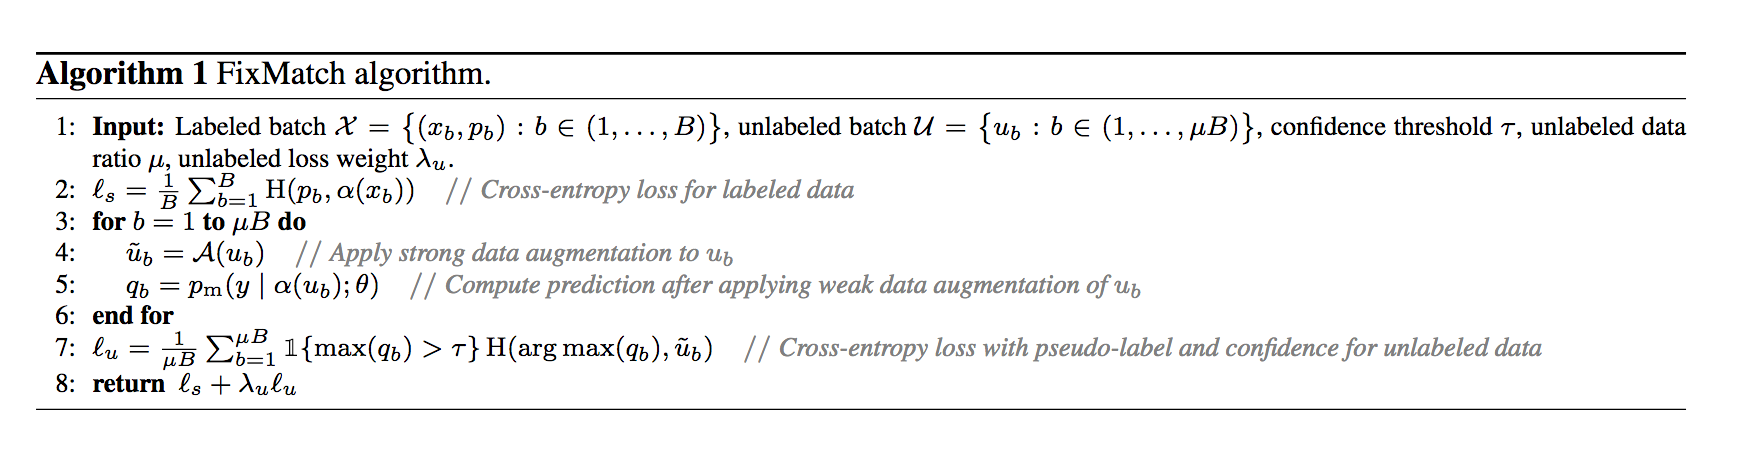


In [ ]:
def sup_prepare_batch(batch, device, non_blocking):
    x = batch["image"].to(device, non_blocking=non_blocking)
    y = batch["target"].to(device, non_blocking=non_blocking)
    return x, y


In [ ]:
confidence_threshold = 0.95
lambda_u = 1.0

In [ ]:
model = WideResNet(num_classes=10).to(device)

if torch.cuda.device_count() > 1:
    model = nn.parallel.DataParallel(model)


sup_criterion = nn.CrossEntropyLoss()
unsup_criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, nesterov=True, weight_decay=weight_decay)

num_epochs = 512  # orginally 1024
epoch_length = 65536 // batch_size
K = num_epochs * epoch_length
lr_scheduler = lrs.CosineAnnealingLR(optimizer, K)


def cycle(dataloader):
    while True:
        for b in dataloader:
            yield b


supervised_train_loader_iter = cycle(supervised_train_loader)
unsupervised_train_loader_iter = cycle(unsupervised_train_loader)


def step():

    model.train()
    optimizer.zero_grad()

    # partie supervisée
    sup_batch = next(supervised_train_loader_iter)
    x, y = sup_prepare_batch(sup_batch, device, non_blocking=True)
    y_pred = model(x)
    sup_loss = sup_criterion(y_pred, y)

    # partie pseudo-labeling
    unsup_batch = next(unsupervised_train_loader_iter)
    weak_x = unsup_batch["image"].to(device, non_blocking=True)
    strong_x = unsup_batch["strong_aug"].to(device, non_blocking=True)

    # logits prédits sur les images augmentées strong
    y_strong_preds = model(??)
    # logits prédits sur les images augmentées weak
    y_weak_preds = model(??)
    # binariser y_weak_preds
    y_pseudo = ??
    # Utiliser torch.softmax() pour obtenir des probas sur y_weak_preds
    y_weak_probas = ??
    # Trouver les valeurs maximales de y_weak_probas
    max_y_weak_probas, _  = ??
    # créer un masque en seuillant avec confidence_threshold. Convertir en float().
    unsup_loss_mask = ??
    # appliquer le masque sur la loss unsup_criterion entre y_strong_preds et y_pseudo, et moyenner.
    unsup_loss = ??

    total_loss = sup_loss + lambda_u * unsup_loss

    total_loss.backward()
    optimizer.step()

    return {
        "total_loss": total_loss,
        "sup_loss": sup_loss,
        "unsup_loss": unsup_loss,
        "non_zero_unsup_loss_density": unsup_loss_mask.mean()
    }


In [ ]:
step()

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def test(device, sup_criterion, test_loader, model, epoch):
    test_loss = 0.0
    top1 = 0.0
    top5 = 0.0

    with torch.no_grad():
        for batch_idx, dico in enumerate(test_loader):
            model.eval()

            inputs = dico["image"]
            targets = dico["target"]
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = sup_criterion(outputs, targets)

            prec1, prec5 = accuracy(outputs, targets, topk=(1, 5))
            test_loss += loss.item()
            top1 += prec1.item()
            top5 += prec5.item()

            # print("Test Iter: {batch:4}/{iter:4}. Loss: {loss:.4f}. top1: {top1:.2f}. top5: {top5:.2f}. ".format(
            #         batch=batch_idx + 1,
            #         iter=len(test_loader),
            #         loss=test_loss,
            #         top1=top1,
            #         top5=top5,
            # ))

    print("top-1 acc: {:.2f}".format(top1/len(test_loader)))
    print("top-5 acc: {:.2f}".format(top5/len(test_loader)))
    return test_loss/len(test_loader), top1/len(test_loader)


In [ ]:
test_loss, test_top1_acc = test(device, sup_criterion, test_loader, model, epoch)

for epoch in range(num_epochs):
    epoch_total_loss, epoch_sup_loss, epoch_unsup_loss  = 0., 0., 0.

    for it in range(epoch_length):
        dico = step()
        epoch_total_loss += dico["total_loss"]
        epoch_sup_loss += dico["sup_loss"]
        epoch_unsup_loss += dico["unsup_loss"]
        if it % 50 == 0:
          print("Batch: {it}/{epoch_length:4} --- Loss: {epoch_total_loss:.5f} sup_loss: {epoch_sup_loss:.5f} unsup_loss: {epoch_unsup_loss:.5f}".format(
              it=it,
              epoch_length=epoch_length,
              epoch_total_loss=epoch_total_loss,
              epoch_sup_loss=epoch_sup_loss,
              epoch_unsup_loss=epoch_unsup_loss
          ))

    epoch_total_loss /= epoch_length
    epoch_sup_loss /= epoch_length
    epoch_unsup_loss /= epoch_length
    print("Train Epoch: {epoch}/{num_epochs:4} --- Loss: {epoch_total_loss:.5f} sup_loss: {epoch_sup_loss:.5f} unsup_loss: {epoch_unsup_loss:.5f}".format(
        epoch=epoch+1,
        num_epochs=num_epochs,
        epoch_total_loss=epoch_total_loss,
        epoch_sup_loss=epoch_sup_loss,
        epoch_unsup_loss=epoch_unsup_loss
    ))
    test_loss, test_top1_acc = test(device, sup_criterion, test_loader, model, epoch)


# Instantier un nouveau modèle et l'entraîner de manière supervisée sur les 250 exemples supervisés